# **Introducción**

### Autores: 
Julio Prado, Javier Matos, Andrea Lara, Jesús Compaire, Jonathan Herrera


El presente proyecto implementa herramientas para la evaluación y visualización de riesgos de llegada de plásticos en el mar e inundación en zonas costeras en el Caribe. Ante la creciente amenaza de eventos meteorológicos extremos y mayor cantidad de basura plástica, este sistema integra datos oceanográficos de modelos y datos satelitales (corrientes marinas y altura de ola) con Modelos Digitales de Terreno (MDT) de alta resolución.

La metodología desarrollada detecta automáticamente la trayectoria de los plásticos en la superficie y su llegada a tierra, con un enfoque que permite identificar cuánto plástico llega a las costas y su comparación con las corrientes geostróficas, además, cuenta con la identificación del foco de tormentas históricas y simular dinámicamente la trayectoria de la marejada ciclónica hasta su impacto en tierra. Mediante algoritmos de agrupamiento espacial (Clustering) y técnicas de visualización geoespacial, el sistema genera mapas de trayectoria de basura y mapas de riesgo detallados que permiten observar las zonas afectadas.

### Objetivo General
Desarrollar un sistema de análisis geoespacial para identificar y cuantificar la trayectoria de basura plástica en el mar y el riesgo de inundación costera, mediante la simulación y el procesamiento de datos espaciales y temporales, con el fin de generar mapas de trayectoria y mapas de riesgo.


# **Importar Librerias**

In [ ]:
import copernicusmarine
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import cmocean as cmo
import pandas as pd
import seaborn as sns
from copy import deepcopy
from sklearn.cluster import DBSCAN
import requests
import os

# **Primeros pasos**

# Inicio del código

### 1. DESCARGA DE DATOS (Actualizada con margen extra)


In [ ]:

print("Verificando archivos de datos...")
try:
    # Altura de ola (Misma config)
    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
        variables=["VHM0"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,     # Ampliado un poco al norte (21)
        start_datetime="2025-08-15T21:00:00",
        end_datetime="2025-08-22T21:00:00",
        output_filename="AlturaOla.nc",
        force_download=True 
    )

    # Corrientes (Dato diario P1D)
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
        variables=["ugos", "vgos"],
        minimum_longitude=-73, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=15, maximum_latitude=21,
        start_datetime="2025-08-15T00:00:00",
        end_datetime="2025-11-22T00:00:00",
        output_filename="Corrientes.nc",
        force_download=True
    )
    print("Datos listos.")
except Exception as e:
    print(f"Nota sobre descarga: {e}")

print("Descarga completada (o archivos ya existentes).")


### 2. CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)


In [69]:
# ---------------------------------------------------------
# 2. CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)
# ---------------------------------------------------------
print("\n--- Generando Semillas de Inicio ---")

# Lista para guardar las partículas. 
# Cada partícula será un diccionario con sus listas de historial.
particulas = []

# Definir puntos específicos
puntos_fijos = [
    {"lat": 20.0, "lon": -72.0, "label": "Punto N-O (20N, 72W)"},
    {"lat": 17.0, "lon": -72.0, "label": "Punto S-O (17N, 72W)"}, 
    {"lat": 20.0, "lon": -70.0, "label": "Punto S-O (20N, 70W)"}
]

# Agregar puntos fijos a la lista
for p in puntos_fijos:
    particulas.append({
        "lat_history": [p["lat"]],
        "lon_history": [p["lon"]],
        "active": True, # Para saber si sigue dentro del mapa
        "label": p["label"],
        "color": "red" # Color distintivo
    })

# Definir línea a lo largo de 68°O (entre 17N y 20N)
# np.linspace crea puntos equidistantes
latitudes_linea = np.linspace(17, 20, num=10) # Creamos 10 partículas a lo largo de la línea
longitud_linea = -68.0

for lat in latitudes_linea:
    particulas.append({
        "lat_history": [lat],
        "lon_history": [longitud_linea],
        "active": True,
        "label": "Línea 68W", # Etiqueta genérica
        "color": "orange" # Color para el grupo de la línea
    })

print(f"Total de partículas creadas: {len(particulas)}")


--- Generando Semillas de Inicio ---
Total de partículas creadas: 13


### 3. SIMULACIÓN DE DERIVA (Multi-partícula)

In [70]:
# ---------------------------------------------------------
# 3. SIMULACIÓN DE DERIVA (Multi-partícula)
# ---------------------------------------------------------
print("Calculando trayectorias...")
ds_curr = xr.open_dataset("Corrientes.nc")
times = ds_curr.time.values
dt = 24 * 3600  # 1 día en segundos

for t in times:
    # Cargar el slice de tiempo UNA sola vez por día para optimizar
    try:
        current_slice = ds_curr.sel(time=t)
    except KeyError:
        break # Fin de datos

    # Iterar sobre cada partícula
    todos_inactivos = True
    for p in particulas:
        if not p["active"]:
            continue
        
        todos_inactivos = False
        
        # Última posición conocida
        lat_actual = p["lat_history"][-1]
        lon_actual = p["lon_history"][-1]

        try:
            # Interpolación (method='linear' es más suave, 'nearest' es más rápido)
            # Usamos nearest para evitar NaNs en bordes costeros complejos
            u = float(current_slice['ugos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)
            v = float(current_slice['vgos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)

            if np.isnan(u) or np.isnan(v):
                p["active"] = False # Tocó tierra o salió del mapa
                continue

            # Cálculo de desplazamiento
            dx = u * dt
            dy = v * dt
            
            d_lat = dy / 111132.0
            d_lon = dx / (111132.0 * np.cos(np.radians(lat_actual)))
            
            # Actualizar
            p["lat_history"].append(lat_actual + d_lat)
            p["lon_history"].append(lon_actual + d_lon)

        except Exception:
            p["active"] = False
            continue
    
    if todos_inactivos:
        print(f"Todas las partículas salieron del dominio en {t}")
        break

Calculando trayectorias...


### 4. GRAFICAR RESULTADOS

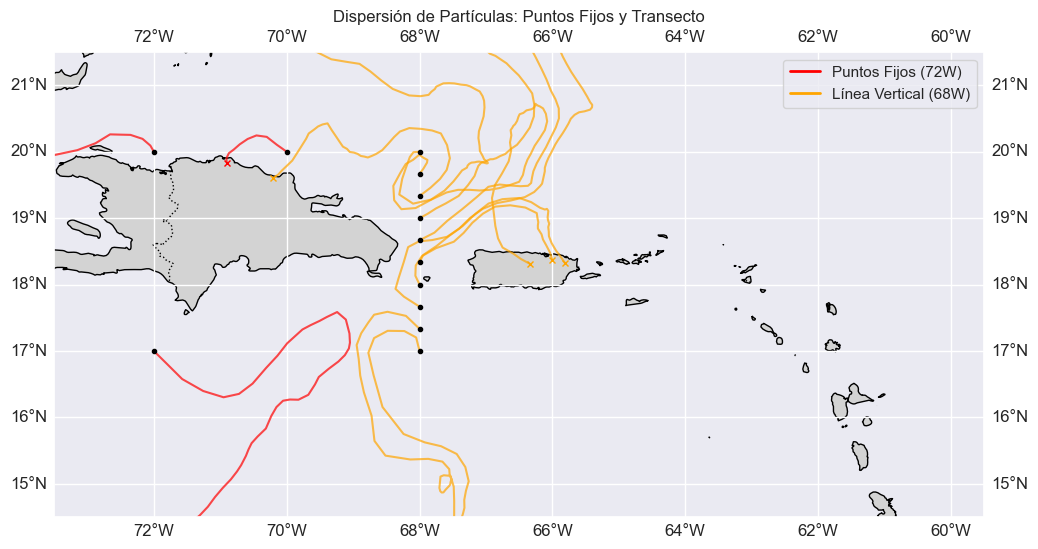

In [71]:
# ---------------------------------------------------------
# 4. GRAFICAR RESULTADOS
# ---------------------------------------------------------
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-73.5, -59.5, 14.5, 21.5], crs=ccrs.PlateCarree())

# Mapa base
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Dibujar trayectorias
for p in particulas:
    # Línea de trayectoria
    ax.plot(p["lon_history"], p["lat_history"], 
            color=p["color"], linewidth=1.5, alpha=0.7, 
            transform=ccrs.PlateCarree())
    
    # Punto de inicio
    ax.plot(p["lon_history"][0], p["lat_history"][0], 
            marker='o', color='black', markersize=3, 
            transform=ccrs.PlateCarree())
    
    # Punto final (flecha o X)
    ax.plot(p["lon_history"][-1], p["lat_history"][-1], 
            marker='x', color=p["color"], markersize=5, 
            transform=ccrs.PlateCarree())

# Truco para la leyenda personalizada (evitar 12 entradas iguales)
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
ax.legend(custom_lines, ['Puntos Fijos (72W)', 'Línea Vertical (68W)'], loc='upper right')

plt.title("Dispersión de Partículas: Puntos Fijos y Transecto")
plt.show()

# **Código modificado en un área más extensa para dos escenarios**

**Descarga Datos de Tormenta**

In [72]:
copernicusmarine.subset(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
    variables=["ugos", "vgos"],
    minimum_longitude=-85,
    maximum_longitude=-60,
    minimum_latitude=11,
    maximum_latitude=25,
    start_datetime="2025-10-18T00:00:00",
    end_datetime="2025-11-27T00:00:00",
    output_filename="Corrientes_tormenta.nc",
    force_download=True
)

WARNING - 2025-11-28T04:11:47Z - 'force_download' has been deprecated.


KeyboardInterrupt: 

**Descarga datos temporada no ciclonica**

In [ ]:
copernicusmarine.subset(
    dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
    variables=["ugos", "vgos"],
    minimum_longitude=-85,
    maximum_longitude=-60,
    minimum_latitude=11,
    maximum_latitude=25,
    start_datetime="2025-01-18T00:00:00",
    end_datetime="2025-03-30T00:00:00",
    output_filename="Corrientes_sin_tormenta.nc",
    force_download=True
)

### **Guardar Corrientes en un Diccionario**

In [73]:
corr_tormenta = xr.open_dataset("Corrientes_tormenta.nc")
coor_normal = xr.open_dataset('Corrientes_sin_tormenta.nc')

In [74]:
diccionario_nc = {
    "corriente_con_tormenta": {
        "data": corr_tormenta,
        "descripcion": "Corrientes oceánicas durante la tormenta"
    },
    "corriente_normal": {
        "data": coor_normal,
        "descripcion": "Corrientes oceánicas en periodo normal"
    }
}

### **CONFIGURACIÓN DE LAS PARTÍCULAS (SEMILLAS)**

**PUNTOS COSTEROS DE RD y PR**

In [75]:
puntos = [
    {
        "lat": 18.46,
        "lon": -69.88,
        "label": "Desembocadura del Río Ozama\n(Ciudad de Santo Domingo, RD)",
        "color": "black"
    },
    {
        "lat": 18.46,
        "lon": -69.30,
        "label": "Desembocadura del Río Soco\n(Ciudad de San Pedro de Macorís, RD)",
        "color": "darkorange"
    },
    {
        "lat": 19.71,
        "lon": -71.74,
        "label": "Desembocadura del Río Yaque del Norte\n(Ciudad de Santiago de los Caballeros, RD)",
        "color": "darkgreen"
    },
    {
        "lat": 18.19,
        "lon": -71.10,
        "label": "Desembocadura del Río Yaque del Sur\n(Barahona, RD)",
        "color": "purple"
    },
    {
        "lat": 18.58,
        "lon": -68.39,
        "label": "Punta Cana, RD",
        "color": "brown"
    },
    {
        "lat": 19.20,
        "lon": -69.20,
        "label": "Bahía de Samaná, RD",
        "color": "crimson"
    },
    {
        "lat": 18.45,
        "lon": -65.87,
        "label": "Río Grande de Loíza (Loíza, PR)",
        "color": "navy"
    },
    {
        "lat": 18.48,
        "lon": -66.25,
        "label": "Río de la Plata (Toa Baja, PR)",
        "color": "magenta"
    },
    {
        "lat": 18.49,
        "lon": -66.53,
        "label": "Río Grande de Manatí (Manatí, PR)",
        "color": "olive"
    },
    {
        "lat": 18.27,
        "lon": -67.20,
        "label": "Río Grande de Añasco (Añasco, PR)",
        "color": "darkslategray"
    }
]


**Lo agregamos al diccionario**

In [76]:
diccionario_nc["Puntos_contaminados_RD_y_PR"] = {
    "puntos_interes": puntos
}

**Generar las Semillas**

In [77]:
print("\n--- Generando Semillas de Inicio ---")
# N = número de partículas por punto
particulas_iniciales = []
N = 45
for p in puntos:
    for _ in range(N):
        # Crear puntos cercanos a los puntos costeros
        lat = p["lat"] + np.random.uniform(-0.15, 0.15)
        lon = p["lon"] + np.random.uniform(-0.15, 0.15)

        particulas_iniciales.append({
            "lat_history": [lat],
            "lon_history": [lon],
            "active": True,
            "label": p["label"],
            "color": p["color"]
        })
print("Partículas agregadas en zonas costeras:", len(puntos) * N)
print("Total de partículas:", len(particulas_iniciales))


--- Generando Semillas de Inicio ---
Partículas agregadas en zonas costeras: 450
Total de partículas: 450


### **Funciones para cálculo de trayectoria**

In [78]:
def calcular_trayectorias(ds_curr, particulas_movidas):
    """
    Calcula la trayectoria de partículas usando un dataset de corrientes.

    Parámetros:
    -----------
    ds_curr : xarray.Dataset
        Dataset que contiene las corrientes 'ugos' y 'vgos'.
    particulas : list de dict
        Lista de partículas. Cada partícula debe tener:
            - 'active': bool
            - 'lat_history': lista de latitudes
            - 'lon_history': lista de longitudes
    dt_segundos : float
        Intervalo de tiempo entre pasos, en segundos. Por defecto 1 día.

    Devuelve:
    ---------
    particulas : list de dict
        La misma lista con las trayectorias actualizadas.
    """
    print("Calculando trayectorias...")

    times = ds_curr.time.values
    dt = 24 * 3600

    for t in times:
        # Cargar el slice de tiempo UNA sola vez por día para optimizar
        try:
            current_slice = ds_curr.sel(time=t)
        except KeyError:
            print(f"No hay datos para el tiempo {t}, terminando cálculo.")
            break

        todos_inactivos = True

        for p in particulas_movidas:
            if not p["active"]:
                continue

            todos_inactivos = False

            lat_actual = p["lat_history"][-1]
            lon_actual = p["lon_history"][-1]

            try:
                u = float(current_slice['ugos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)
                v = float(current_slice['vgos'].sel(latitude=lat_actual, longitude=lon_actual, method='nearest').values)

                if np.isnan(u) or np.isnan(v):
                    p["active"] = False
                    continue

                dx = u * dt
                dy = v * dt

                d_lat = dy / 111132.0
                d_lon = dx / (111132.0 * np.cos(np.radians(lat_actual)))

                # Actualizar la posición
                p["lat_history"].append(lat_actual + d_lat)
                p["lon_history"].append(lon_actual + d_lon)

            except Exception:
                p["active"] = False
                continue

        if todos_inactivos:
            print(f"Todas las partículas salieron del dominio en {t}")
            break

    print("Cálculo listo")
    return particulas_movidas


**Funcion para Reiniciar el Estado**

In [79]:
def reiniciar_particulas(particulas):
    for p in particulas:
        p["active"] = True
        p["lat_history"] = [p["lat_history"][0]]
        p["lon_history"] = [p["lon_history"][0]]

### **Simulacion de la Deriva durante Tormenta**

**Copiamos las particulas para asegurarnos de que no se muevan a la hora de realizar el modelaje**

In [80]:
particulas_tormenta = deepcopy(particulas_iniciales)
particulas_sin_tormenta = deepcopy(particulas_iniciales)

**Subimos ambos datasets**

In [81]:
ds_curr = xr.open_dataset("Corrientes_tormenta.nc")
ds_curr_sintor= xr.open_dataset('Corrientes_sin_tormenta.nc')

In [82]:
trayectoria_tormenta= calcular_trayectorias(ds_curr, particulas_movidas= particulas_tormenta)

Calculando trayectorias...
Cálculo listo


**Agregamos las Particulas en Escenario de Tormenta al Diccionario**

In [83]:
diccionario_nc["corriente_con_tormenta"]["particulas"] = trayectoria_tormenta

### **Calculo con Corrientes normales**

In [84]:
reiniciar_particulas(particulas_sin_tormenta)

In [85]:
trayectoria_sin_tormenta= calcular_trayectorias(ds_curr_sintor, particulas_movidas= particulas_sin_tormenta)

Calculando trayectorias...
Cálculo listo


**Agregamos las Particulas en Escenario Normal al Diccionario**

In [86]:
diccionario_nc['corriente_normal']['particulas'] = trayectoria_sin_tormenta

### **Grafica usando particulas del Diccionario**

**Funcion para Grafica de Mapas**

In [87]:
def crear_mapa(titulo, escenario):
    """
    Creamos dos mapas a para comparar escenarios
    Titulo= al titulo que deseamos otorgarle al mapa
    Escenario = Escenario de tormenta o no tormenta.
    """
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-85, -60, 11, 25], crs=ccrs.PlateCarree())

    # Mapa base
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=2)
    ax.add_feature(cfeature.OCEAN, facecolor='dodgerblue')
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Dibujar trayectorias
    for p in escenario:
        ax.plot(p["lon_history"], p["lat_history"],
                color=p["color"], linewidth=1.5, alpha=0.7,
                transform=ccrs.PlateCarree())

        ax.plot(p["lon_history"][0], p["lat_history"][0],
                marker='o', color='black', markersize=3,
                transform=ccrs.PlateCarree())

        ax.plot(p["lon_history"][-1], p["lat_history"][-1],
                marker='x', color=p["color"], markersize=5,
                transform=ccrs.PlateCarree())

    # Leyenda
    leyenda_puntos = [
        Line2D([0], [0], marker='o', color='w',
               label=p["label"],
               markerfacecolor=p["color"],
               markersize=8)
        for p in puntos
    ]

    ax.legend(
        handles=leyenda_puntos,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.35),
        ncol=4,
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        facecolor='snow',
        title="Puntos de origen de partículas plásticas",
        prop={'weight': 'bold'},
        title_fontproperties={'weight': 'bold'}
    )

    plt.title(titulo, fontweight='bold', y=1.07)
    plt.show()

### **Fechas de los datos**

In [88]:
tiem_ciclonica = diccionario_nc['corriente_con_tormenta']['data']
tiemp_no_ciclonica = diccionario_nc['corriente_normal']['data']

In [89]:
tiempo_ciclonico_max= tiem_ciclonica.time.values.max()
tiempo_ciclonico_min= tiem_ciclonica.time.values.min()

t_max_fmt = pd.to_datetime(tiempo_ciclonico_max).strftime('%Y-%m-%d')
t_min_fmt = pd.to_datetime(tiempo_ciclonico_min).strftime('%Y-%m-%d')

print(f'el tiempo maximo de la temporada ciclonica es {t_max_fmt}')
print(f'el tiempo minimo de la temporada ciclonica es {t_min_fmt}')

el tiempo maximo de la temporada ciclonica es 2025-11-27
el tiempo minimo de la temporada ciclonica es 2025-10-18


In [90]:
tiempo_no_ciclonico_max= tiem_ciclonica.time.values.max()
tiempo_no_ciclonico_min= tiem_ciclonica.time.values.min()

t_max_fmt2 = pd.to_datetime(tiempo_no_ciclonico_max).strftime('%Y-%m-%d')
t_min_fmt2 = pd.to_datetime(tiempo_no_ciclonico_min).strftime('%Y-%m-%d')

print(f'el tiempo maximo de la temporada NO ciclonica es {t_max_fmt2}')
print(f'el tiempo minimo de la temporada NO ciclonica es {t_min_fmt2}')

el tiempo maximo de la temporada NO ciclonica es 2025-11-27
el tiempo minimo de la temporada NO ciclonica es 2025-10-18


### **Graficar mapas con escenarios**

**Con efecto de la tormenta**

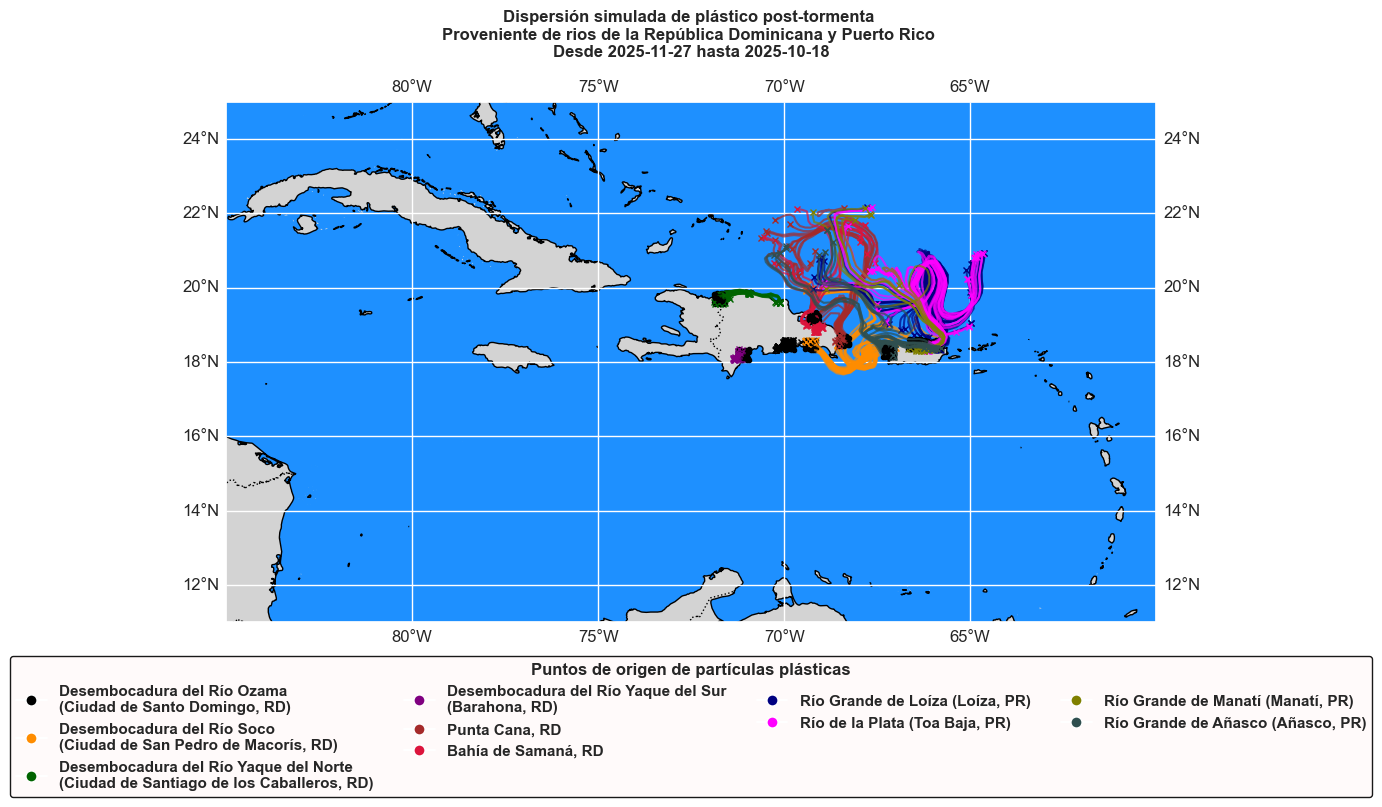

In [91]:
crear_mapa(f'Dispersión simulada de plástico post-tormenta \nProveniente de rios de la República Dominicana y Puerto Rico \nDesde {t_max_fmt} hasta {t_min_fmt}',
           escenario= diccionario_nc['corriente_con_tormenta']['particulas'])

**Mapa En Condiciones Normales**

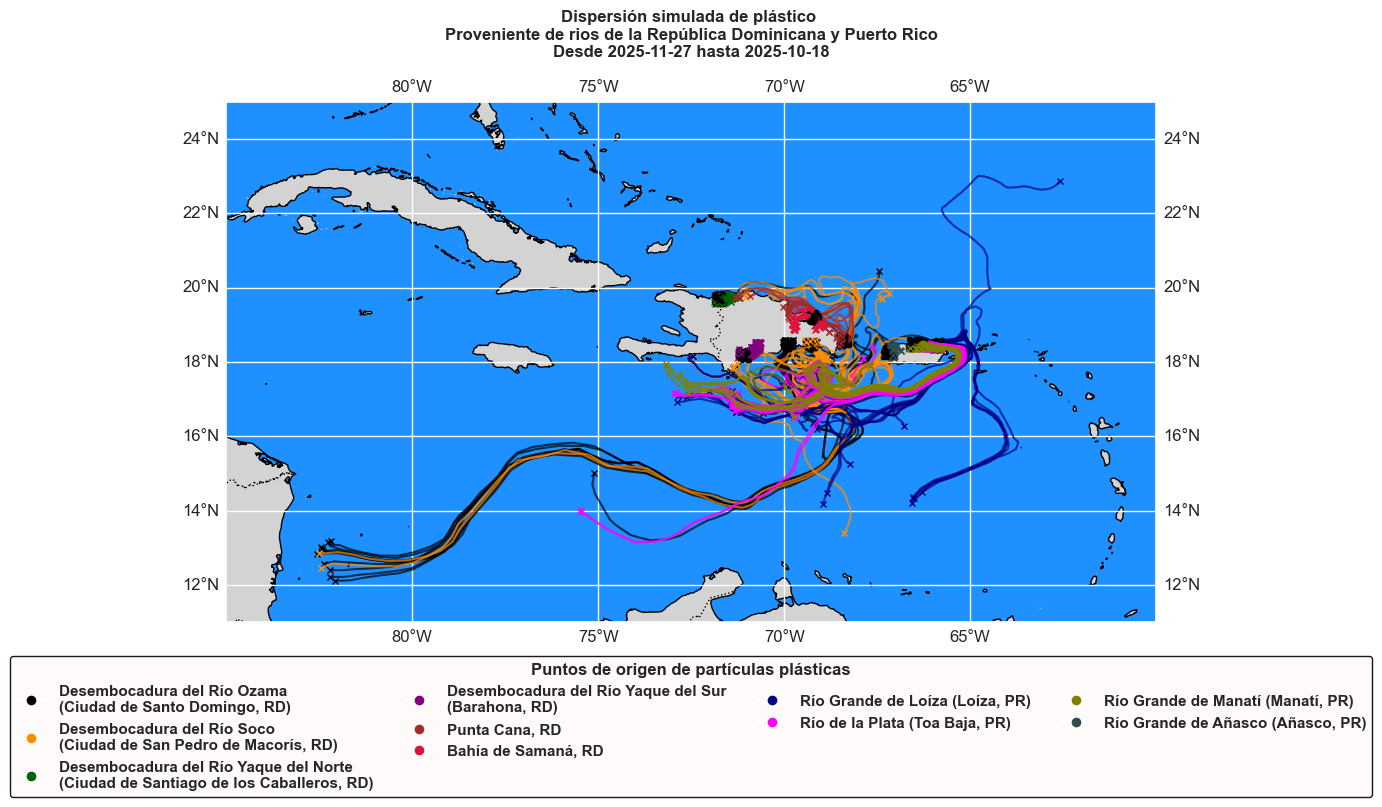

In [92]:
crear_mapa(f'Dispersión simulada de plástico \nProveniente de rios de la República Dominicana y Puerto Rico\nDesde {t_max_fmt2} hasta {t_min_fmt2}',
           escenario= diccionario_nc['corriente_normal']['particulas'])

### **Cantidad de Particulas que Llegan a Tiera**

**Funcion a Graficar**

In [93]:
def grafico_circulacion(titulo, dataset_corriente, particulas):

    data = dataset_corriente.mean(dim='time', keep_attrs=True)

    velo = np.sqrt(data.ugos**2 + data.vgos**2)

    fig, ax = plt.subplots(figsize=(12, 9),
                           subplot_kw={'projection': ccrs.PlateCarree()})

    ax.set_extent([-78, -60, 11, 22], crs=ccrs.PlateCarree())

    # ===== MAPA DE VELOCIDAD =====
    c = ax.pcolormesh(
        data.longitude,
        data.latitude,
        velo,
        transform=ccrs.PlateCarree(),
        cmap=cmo.cm.delta,
        vmin=0,
        vmax=0.7,
        zorder=0
    )

    cbar = plt.colorbar(c, ax=ax, pad=0.05, shrink=0.8)
    cbar.set_label('Velocidad de la corriente (m/s)')

    # ===== VECTORES =====
    skip = (slice(None, None, 3), slice(None, None, 3))

    q = ax.quiver(
        data.longitude[skip[1]],
        data.latitude[skip[0]],
        data.ugos[skip],
        data.vgos[skip],
        transform=ccrs.PlateCarree(),
        scale=5,
        width=0.002,
        color='white',
        zorder=10
    )

    ax.quiverkey(q, 0.9, 1.03, 0.2, '0.2 m/s',
                 labelpos='E', coordinates='axes')

    # ===== TRAYECTORIAS =====
    for p in particulas:
        ax.plot(p["lon_history"], p["lat_history"],
                color=p["color"], linewidth=1.5, alpha=0.7,
                transform=ccrs.PlateCarree())

        ax.plot(p["lon_history"][0], p["lat_history"][0],
                marker='o', color='black', markersize=3,
                transform=ccrs.PlateCarree())

        ax.plot(p["lon_history"][-1], p["lat_history"][-1],
                marker='x', color=p["color"], markersize=5,
                transform=ccrs.PlateCarree())

    # ===== LEYENDA =====
    leyenda_puntos = [
        Line2D([0], [0], marker='o', color='w',
               label=p["label"],
               markerfacecolor=p["color"],
               markersize=8)
        for p in puntos
    ]

    ax.legend(
        handles=leyenda_puntos,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.4),
        ncol=4,
        frameon=True,
        framealpha=0.9,
        edgecolor='black',
        facecolor='snow',
        prop={'weight': 'bold'}
    )

    ax.add_feature(cfeature.LAND, facecolor='gray', zorder=5)
    ax.add_feature(cfeature.COASTLINE, zorder=6)

    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = True
    gl.bottom_labels = False
    gl.left_labels = True
    gl.right_labels = False

    ax.set_title(titulo, fontweight='bold', y=1.05)

    plt.show()


In [94]:
corr_tormenta = xr.open_dataset("Corrientes_tormenta.nc")
coor_normal = xr.open_dataset('Corrientes_sin_tormenta.nc')

### Comparación de trayectoria para circulación geostrofica

**Temporada Ciclonica**

In [95]:
grafico_circulacion(
    f'Dispersión simulada de plástico \nProveniente de ríos de la República Dominicana y Puerto Rico\n en Temporada No Ciclónica desde {t_max_fmt2} hasta {t_min_fmt2}',
    dataset_corriente=coor_normal,
    particulas=diccionario_nc['corriente_normal']['particulas']
)

KeyboardInterrupt: 

**Temporada No Ciclonica**

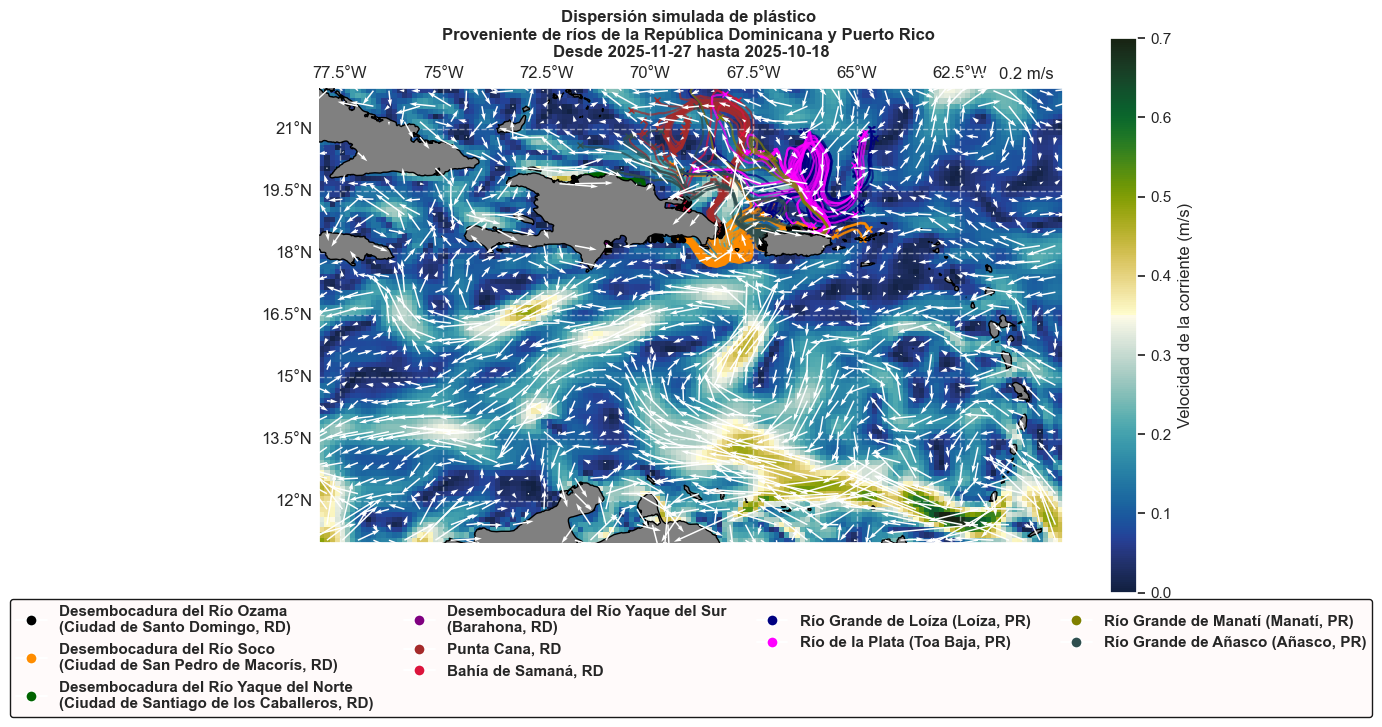

In [ ]:
grafico_circulacion(
    f'Dispersión simulada de plástico \nProveniente de ríos de la República Dominicana y Puerto Rico \nDesde {t_max_fmt2} hasta {t_min_fmt2}',
    dataset_corriente=corr_tormenta,
    particulas=diccionario_nc['corriente_con_tormenta']['particulas']
)

### **Cantidad de Particulas que Llegan a Tierra**

In [ ]:
particulas= diccionario_nc['corriente_con_tormenta']['particulas']
total = len(particulas)
inactivas = sum(not p["active"] for p in particulas)
activas = sum(p["active"] for p in particulas)

print(f"Total de partículas: {total}")
print(f"Partículas que llegaron a tierra {inactivas}")
print(f"Partículas que siguen en el mar: {activas}")

df_particulas = pd.DataFrame({
    'Categoría': ['Tierra', 'Mar'],
    'Cantidad': [inactivas, activas]
})

sns.set_theme(style='darkgrid')
colors= ['blue', 'brown']
# Gráfico de barras
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Categoría', y='Cantidad', data=df_particulas,
                 palette= colors, edgecolor= 'black')

# Añadir etiquetas encima de las barras
for i, v in enumerate(df_particulas['Cantidad']):
    ax.text(i, v + 5, str(v), color='black', ha='center', fontweight='bold')

plt.title('Distribución de partículas de Plástico \nDurante Temporada Ciclonica', fontweight= 'bold')
plt.show()

**Temporada Ciclonica**

In [ ]:
particulas= diccionario_nc['corriente_normal']['particulas']
total = len(particulas)
inactivas = sum(not p["active"] for p in particulas)
activas = sum(p["active"] for p in particulas)

print(f"Total de partículas: {total}")
print(f"Partículas que llegaron a tierra {inactivas}")
print(f"Partículas que siguen en el mar: {activas}")

df_particulas = pd.DataFrame({
    'Categoría': ['Tierra', 'Mar'],
    'Cantidad': [inactivas, activas]
})

sns.set_theme(style='darkgrid')
colors= ['blue', 'brown']
# Gráfico de barras
plt.figure(figsize=(6,4))
ax = sns.barplot(x='Categoría', y='Cantidad', data=df_particulas,
                 palette= colors, edgecolor= 'black')

# Añadir etiquetas encima de las barras
for i, v in enumerate(df_particulas['Cantidad']):
    ax.text(i, v + 5, str(v), color='black', ha='center', fontweight='bold')

plt.title('Distribución de partículas de Plástico \nDurante Temporada no Ciclonica', fontweight= 'bold')
plt.show()

## **Zonas de riesgo de inundación**
### Descarga de datos MDT, Oleaje y Corrientes para una zona más extensa

In [ ]:
# ---------------------------------------------------------
# 1. DESCARGA DE DATOS (Actualizada con margen extra)
# ---------------------------------------------------------
print("Verificando archivos de datos...")
try:
    # Altura de ola (Misma config)
    copernicusmarine.subset(
        dataset_id="cmems_mod_glo_wav_anfc_0.083deg_PT3H-i",
        variables=["VHM0"],
        minimum_longitude=-85, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=11, maximum_latitude=25,     # Ampliado un poco al norte (21)
        start_datetime="2025-08-15T21:00:00",
        end_datetime="2025-08-22T21:00:00",
        output_filename="AlturaOlaEx.nc",
        force_download=True
    )

    # Corrientes (Dato diario P1D)
    copernicusmarine.subset(
        dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.125deg_P1D",
        variables=["ugos", "vgos"],
        minimum_longitude=-85, maximum_longitude=-60, # Ampliado a -73
        minimum_latitude=11, maximum_latitude=25,
        start_datetime="2025-08-15T00:00:00",
        end_datetime="2025-11-22T00:00:00",
        output_filename="CorrientesEx.nc",
        force_download=True
    )
    print("Datos listos.")
except Exception as e:
    print(f"Nota sobre descarga: {e}")

print("Descarga completada (o archivos ya existentes).")

### **FUNCIÓN DE DESCARGA ROBUSTA (Chunked Download)**

In [ ]:

def descargar_mdt_seguro(filename="MDT_Caribe_Riesgo.nc"):
    print(f"Iniciando descarga segura de: {filename}")
    # URL corregida y simplificada del servidor NOAA ERDDAP
    # Solicitamos ETOPO1 (Bedrock), recortado a tu zona exacta
    url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(10):1:(26)][(-85):1:(-59)]"

    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            downloaded = 0

            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
                    downloaded += len(chunk)
                    # Barra de progreso simple
                    if total_size > 0:
                        percent = (downloaded / total_size) * 100
                        print(f"Descargando: {percent:.1f}%", end='\r')

        print(f"\n¡Descarga completada! Guardado en {filename}")
        return True
    except Exception as e:
        print(f"\nError fatal en descarga: {e}")
        return False

# Ejecutar descarga si no existe el archivo
import os
if not os.path.exists("MDT_Caribe_Riesgo.nc"):
    exito = descargar_mdt_seguro()
else:
    print("El archivo MDT ya existe. Saltando descarga.")
    exito = True

El archivo MDT ya existe. Saltando descarga.


### **Identificación de ola max de tormenta y zonas de riesgo para el area de interes**

Cargando datos y buscando la tormenta...
📍 TORMENTA DETECTADA:
   📅 Fecha: 2025-08-19 06:00:00
   🌍 Ubicación: 24.833 N, -71.500 W
   🌊 Altura Ola Pico: 15.93 metros

Simulando desplazamiento de la marejada...

⚠️ ¡ALERTA! Se detectaron impactos en 3 zonas costeras.
   Nivel de agua estimado para inundación: 4.03 m


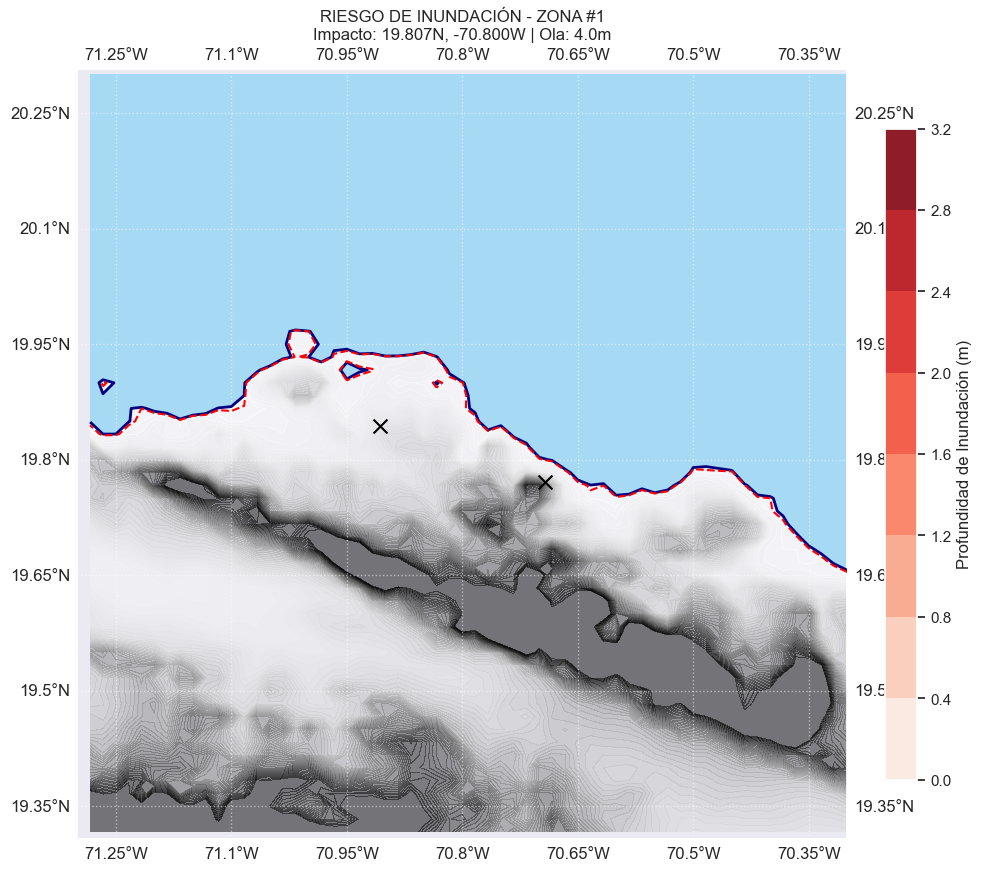

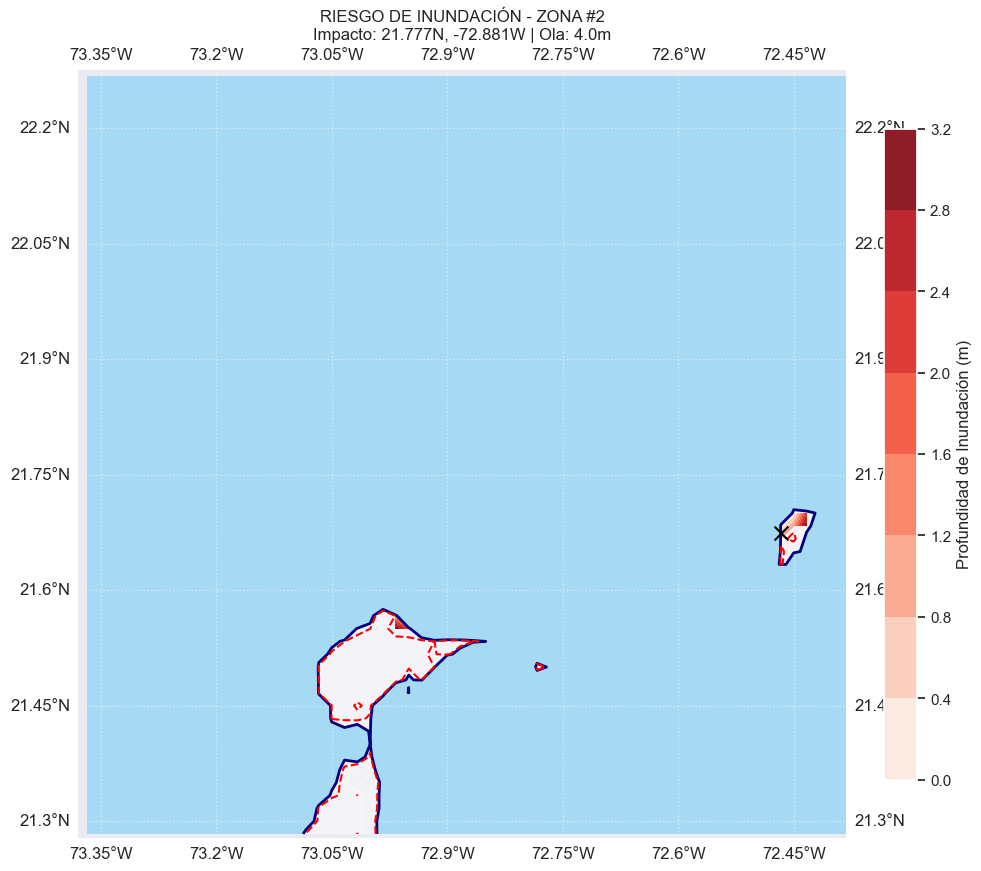

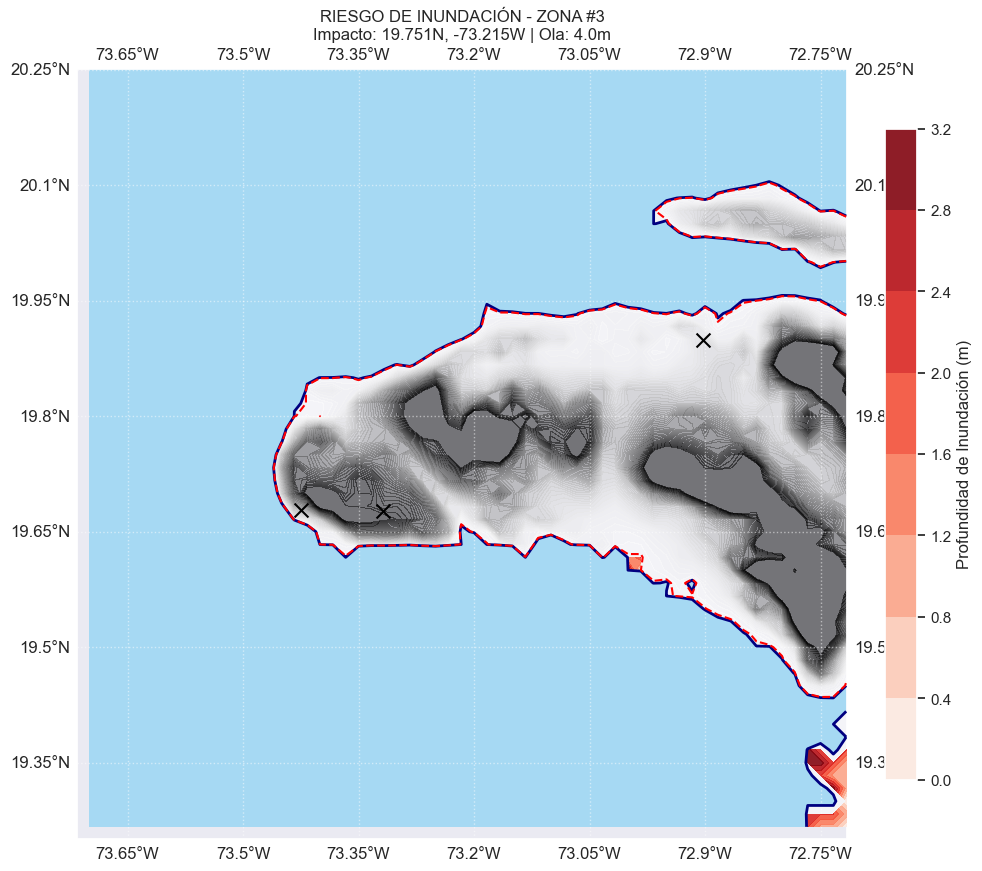

In [96]:
# --- 2. CARGA DE DATOS Y DETECCIÓN DE TORMENTA ---
print("Cargando datos y buscando la tormenta...")
ds_waves = xr.open_dataset("AlturaOlaEx.nc")
ds_curr = xr.open_dataset("CorrientesEx.nc")
ds_mdt = xr.open_dataset("MDT_Caribe_Riesgo.nc")

# Encontrar el máximo histórico
vhm0 = ds_waves['VHM0']
max_val = vhm0.max()
storm_point = vhm0.where(vhm0 == max_val, drop=True)

storm_time = storm_point.time.values[0]
storm_lat = float(storm_point.latitude.values[0])
storm_lon = float(storm_point.longitude.values[0])
storm_height = float(storm_point.values[0].item())

print(f"📍 TORMENTA DETECTADA:")
print(f"   📅 Fecha: {pd.to_datetime(storm_time)}")
print(f"   🌍 Ubicación: {storm_lat:.3f} N, {storm_lon:.3f} W")
print(f"   🌊 Altura Ola Pico: {storm_height:.2f} metros")

# --- 3. SIMULACIÓN DE TRAYECTORIA ---
print("\nSimulando desplazamiento de la marejada...")
particulas = []
radio_dispersion = 0.5

for i in range(50):
    lat_r = storm_lat + np.random.uniform(-radio_dispersion, radio_dispersion)
    lon_r = storm_lon + np.random.uniform(-radio_dispersion, radio_dispersion)
    particulas.append({
        "lat": [lat_r], "lon": [lon_r], "active": True, "impacto": False
    })

times_sim = ds_curr.time.sel(time=slice(storm_time, None)).values
dt = 24 * 3600

for t in times_sim:
    try:
        curr_slice = ds_curr.sel(time=t, method='nearest')
    except: continue

    todos_inactivos = True
    for p in particulas:
        if not p["active"]: continue
        todos_inactivos = False

        lat, lon = p["lat"][-1], p["lon"][-1]

        try:
            elev = float(ds_mdt['altitude'].sel(latitude=lat, longitude=lon, method='nearest').values)
            if elev > 0:
                p["active"] = False
                p["impacto"] = True
                continue
        except: pass

        try:
            u = float(curr_slice['ugos'].sel(latitude=lat, longitude=lon, method='nearest').values)
            v = float(curr_slice['vgos'].sel(latitude=lat, longitude=lon, method='nearest').values)
            if np.isnan(u):
                p["active"] = False
                continue
            p["lat"].append(lat + (v * dt / 111132.0))
            p["lon"].append(lon + (u * dt / (111132.0 * np.cos(np.radians(lat)))))
        except: p["active"] = False

    if todos_inactivos: break

# --- 4. ANÁLISIS DE IMPACTO CON ZOOM (MEJORADO VISUALMENTE) ---
impactos = np.array([[p["lon"][-1], p["lat"][-1]] for p in particulas if p["impacto"]])

if len(impactos) > 0:
    clustering = DBSCAN(eps=0.8, min_samples=1).fit(impactos)
    labels = clustering.labels_
    unique_labels = set(labels)
    if -1 in unique_labels: unique_labels.remove(-1)

    print(f"\n⚠️ ¡ALERTA! Se detectaron impactos en {len(unique_labels)} zonas costeras.")

    cota_inundacion = storm_height * 0.25 + 0.05
    print(f"   Nivel de agua estimado para inundación: {cota_inundacion:.2f} m")

    for label_id in unique_labels:
        puntos_zona = impactos[labels == label_id]
        c_lon = np.mean(puntos_zona[:, 0])
        c_lat = np.mean(puntos_zona[:, 1])

        # Zoom de 0.5 grados
        zoom = 0.5
        lat_min, lat_max = c_lat - zoom, c_lat + zoom
        lon_min, lon_max = c_lon - zoom, c_lon + zoom

        lat_slice = sorted([lat_min, lat_max])
        lon_slice = sorted([lon_min, lon_max])

        subset = ds_mdt.sel(latitude=slice(lat_slice[0], lat_slice[1]),
                            longitude=slice(lon_slice[0], lon_slice[1]))

        if subset['altitude'].size == 0: continue

        elev = subset['altitude']
        mask_flood = (elev > 0) & (elev < cota_inundacion)
        profundidad = (cota_inundacion - elev).where(mask_flood)

        # --- GRAFICAR ZOOM (CORREGIDO - TIERRA FIRME) ---
        fig = plt.figure(figsize=(12, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # 1. Pintar explícitamente el MAR (z <= 0) de Azul
        # Usamos contourf con un solo nivel para "rellenar" todo lo que sea mar
        ax.contourf(subset.longitude, subset.latitude, elev,
                    levels=[-10000, 0], colors=['#a6d9f3'], zorder=1)

        # 2. Pintar TIERRA SEGURA (z > 0) de Gris
        # Importante: Empezamos en 0.01 para cubrir toda la tierra positiva
        ax.contourf(subset.longitude, subset.latitude, elev,
                    levels=np.arange(0, 500, 10), cmap='Greys', alpha=0.5, zorder=2, extend='max')

        # 3. Pintar INUNDACIÓN (Rojo sobre la tierra)
        if np.any(mask_flood):
            flood_plot = ax.contourf(subset.longitude, subset.latitude, profundidad,
                                     cmap='Reds', alpha=0.9, zorder=5)
            # Barra de profundidad más pequeña y limpia
            cbar = plt.colorbar(flood_plot, ax=ax, label="Profundidad de Inundación (m)", fraction=0.035, pad=0.04)

        # 4. Líneas de referencia (Contornos)
        # Costa (Nivel 0 exacto) en Azul Oscuro
        ax.contour(subset.longitude, subset.latitude, elev, levels=[0],
                   colors='navy', linewidths=2, zorder=6)

        # Límite de Inundación (Cota Máxima) en Rojo
        ax.contour(subset.longitude, subset.latitude, elev, levels=[cota_inundacion],
                   colors='red', linestyles='--', linewidths=1.5, zorder=6)

        # 5. Puntos de impacto
        ax.scatter(puntos_zona[:,0], puntos_zona[:,1], c='black', marker='x', s=100, label='Impacto Ola', zorder=10)

        # Decoración
        ax.gridlines(draw_labels=True, linestyle=':', alpha=0.5)
        plt.title(f"RIESGO DE INUNDACIÓN - ZONA #{label_id+1}\nImpacto: {c_lat:.3f}N, {c_lon:.3f}W | Ola: {cota_inundacion:.1f}m")
        plt.show()
else:
    print("La tormenta se disipó en el mar sin tocar tierra.")